In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
years = range(2000,2020,4)
df = pd.read_csv('counties.csv')


In [3]:
data = df.drop(columns=['state', 'county'])
data = data.dropna(axis=0,how='any')
data.describe()

,2000D,2000R,2000O,2004D,2004R,2004O,2008D,2008R,2008O,2012D,2012R,2012O,2016D,2016R,2016O
count,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2.875000e+03,2875.000000,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000
mean,1.699424e+04,16533.856000,1352.073391,1.956915e+04,2.028555e+04,508.671652,2.298134e+04,19539.632696,610.991304,2.171365e+04,19761.090783,886.516522,2.175607e+04,20524.178783,2543.772522
std,5.942532e+04,39923.542134,4232.141433,6.769202e+04,4.869764e+04,1976.171276,7.944593e+04,45955.629730,1913.652362,7.628626e+04,45649.528293,3056.034805,8.298175e+04,44262.493478,7726.198627
min,1.400000e+01,106.000000,3.000000,1.200000e+01,6.500000e+01,0.000000,8.000000e+00,67.000000,0.000000,5.000000e+00,54.000000,1.000000,4.000000e+00,58.000000,3.000000
25%,1.751500e+03,2689.000000,109.000000,1.882500e+03,3.124500e+03,43.000000,1.930500e+03,2956.000000,78.500000,1.662500e+03,3021.500000,84.000000,1.240000e+03,3346.000000,195.000000
50%,3.830000e+03,5363.000000,278.000000,4.177000e+03,6.522000e+03,98.000000,4.493000e+03,6297.000000,182.000000,4.014000e+03,6398.000000,195.000000,3.199000e+03,7194.000000,529.000000
75%,9.580500e+03,13166.000000,886.500000,1.078350e+04,1.646800e+04,302.000000,1.262450e+04,16042.000000,453.500000,1.147700e+04,16391.500000,564.000000,9.940500e+03,17945.500000,1736.500000
max,1.710505e+06,871930.000000,112719.000000,1.907736e+06,1.076225e+06,39515.000000,2.295853e+06,956425.000000,65970.000000,2.216903e+06,885333.000000,78831.000000,2.464364e+06,769743.000000,200201.000000


In [4]:
data = data.to_numpy(dtype=np.int64)

In [34]:
def plotCounty(state,county,d,r,o,predicted=None):
    years = range(2000,2020,4)
    plt.figure()
    plt.plot(years,d,'b',label='Democrat')
    plt.plot(years,r,'r',label='Republican')
    plt.plot(years,o,'y',label='Other')
    plt.plot(years,d+r+o,'k',label='Total')
    if predicted is not None:
        new_years = range(2008,2024,4)
        plt.plot(new_years,predicted[0]*20000,'c',label='Democrat Model')
        plt.plot(new_years,predicted[1]*20000,'m',label='Republican Model')
        plt.plot(new_years,predicted[2]*250,'g',label='Other Model')
    plt.xlabel('Year')
    plt.ylabel('Votes')
    plt.title(county+', '+state)
    plt.xticks(years)
    plt.legend()
    plt.show()

In [6]:
def calcState(state):
    state_df = df[df['state']==state]
    state_df = state_df.drop(columns=['state','county'])
    state_votes = state_df.values.tolist()
    state_votes = np.array(state_votes)
    state_votes = np.sum(state_votes,axis=0,dtype=np.int64)
    d = []
    r = []
    o = []
    for ind, val in enumerate(state_votes):
        party = ind % 3
        if party == 0:
            d.append(val)
        elif party == 1:
            r.append(val)
        else:
            o.append(val)
    d = np.array(d)
    r = np.array(r)
    o = np.array(o)
    return d,r,o

In [7]:
def plotState(state,d,r,o):
    years = range(2000,2020,4)
    plt.figure()
    plt.plot(years,d,'b',label='Democrat')
    plt.plot(years,r,'r',label='Republican')
    plt.plot(years,o,'y',label='Other')
    plt.plot(years,d+r+o,'k',label='Total')
    plt.xlabel('Year')
    plt.ylabel('Votes')
    plt.title(state)
    plt.xticks(years)
    plt.legend()
    plt.show()

In [8]:
def convertbyParty(point):
    d = point[:,::3]/20000
    r = point[:,1::3]/20000
    o = point[:,2::3]/250
    return d,r,o

In [23]:
def getDataset(data,batch_size,split=True):
    data = np.expand_dims(data,axis=-1)
    np.random.shuffle(data)
    num = data.shape[0]
    train_data = data[:int(num*0.6)]
    val_data = data[int(num*0.6):int(num*0.8)]
    test_data = data[int(num*0.8):]
    def createDS(point,label=True):
        d,r,o=convertbyParty(point)
        new_data = np.array((d,r,o))
        new_data = np.swapaxes(new_data,0,1)
        ds = tf.data.Dataset.from_tensor_slices(new_data)
        if label:
            ds = ds.map(lambda p: (p[:,:-1],p[:,1:]))
        else:
            ds = ds.map(lambda p: p[:,1:])
        return ds.batch(batch_size).prefetch(1)
    if split:
        return createDS(train_data),createDS(val_data),createDS(test_data)
    else:
        return createDS(data,False)

In [10]:
train_ds, val_ds, test_ds = getDataset(data,2)
train_ds


<PrefetchDataset shapes: ((None, 3, 4, 1), (None, 3, 4, 1)), types: (tf.float64, tf.float64)>

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(2,(2,2),activation='relu',input_shape=(3,4,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12,activation='relu'),
    tf.keras.layers.Reshape((3,4,1)),
])

In [12]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(16,activation='relu',input_shape=(3,4,1)),
#     tf.keras.layers.Dense(32,activation='relu'),
#     tf.keras.layers.Dense(64,activation='relu')
#     tf.keras.layers.Dense(1)
# ])

In [13]:
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3, 4, 16)          32        
_________________________________________________________________
dense_1 (Dense)              (None, 3, 4, 32)          544       
_________________________________________________________________
dense_2 (Dense)              (None, 3, 4, 1)           33        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint16.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)

In [15]:
model.fit(train_ds,epochs=400,validation_data=val_ds,callbacks=[model_checkpoint,early_stopping])

Epoch 1/400
863/863 [==============================] - 4s 5ms/step - loss: 72.1098 - val_loss: 65.1818

In [26]:
c = 'Kenosha'
s = 'WI'
r = df[(df['state']==s)&(df['county']==c)]

In [27]:
model2 = tf.keras.models.load_model('checkpoint2.h5')
model4 = tf.keras.models.load_model('checkpoint4.h5')
row = r.drop(columns=['state','county'])
row = row.to_numpy()
dataset = getDataset(row,2,False)

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00


0.0

In [36]:
results = model2.predict(dataset)
results[0][0].shape

(4, 1)

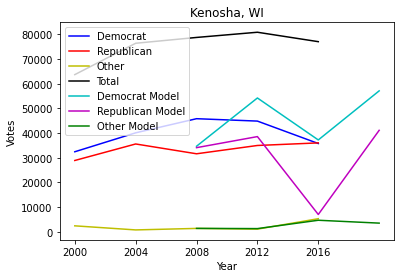

In [37]:
dem = np.array(r.values.tolist()[0][2::3])
gop = np.array(r.values.tolist()[0][3::3])
other = np.array(r.values.tolist()[0][4::3])
plotCounty(s,c,dem,gop,other,results[0])